# Programming assignment 09: Deep Learning

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

## Your Task

In this notebook, the skeleton for learning a feed-forward neural network is given. Your task is to complete the functions where required.

## Submission

**Submit your notebook by January 6, 2019** as a .html file with your code and the respective cell outputs.

You can also take part in our challenge to fit the best model to the cell phone data by submitting your predictions for the test data. The winners of the challenge will be announced after the Christmas break! See the bottom of this file for more information.

## Load and Preprocess Data

I this assignment we will work with a dataset containing accelerometer and gyroscope sensor signals of a cell-phone. Given the sensor signals, the task is to predict the activity that the cell-phone user is doing, e.g, running, walking, biking, or moving upstairs.

The data consists of 8032 samples. Each feature vector contains 6 measurements from the cell-phone sensors in 20 consequent time steps. Indeed, each feature vector is 120-dimensional. The task is to classify these instances into the following classes: "Walking", "Standing", "Sitting", "Running", "Upstairs", "Downstairs".

More details can be found here: https://becominghuman.ai/deep-learning-for-sensor-based-human-activity-recognition-970ff47c6b6b 

**Before you start** download the data from https://syncandshare.lrz.de/dl/fiXnRq4MRd8fGJBXH2jQmNcN/homework_09_data.npz and place the file into the same directory as this notebook.

In [3]:
loader = np.load("homework_09_data.npz")
train_data = loader['train_data']
train_labels = loader['train_labels']

val_data = loader['val_data']
val_labels = loader['val_labels']

test_data = loader['test_data']

print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)

(4819, 120)
(4819, 6)
(1606, 120)
(1606, 6)
(1607, 120)


In [6]:
# Normalize (between [0,1])? or standardize(mean=0, std=1)? for cnn data
def standardize(train, test):
    """ Standardize data """
    train = train.astype(np.float32)
    test = test.astype(np.float32)
    # Standardize train and test
    X_train = (train - np.mean(train, axis=0)) / np.std(train, axis=0)
    X_test = (test - np.mean(test, axis=0)) / np.std(test, axis=0)

    return X_train, X_test

train_data, val_data = standardize(train_data, val_data)
_, test_data = standardize(val_data, test_data)

print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)

(4819, 120)
(4819, 6)
(1606, 120)
(1606, 6)
(1607, 120)


The skeleton of the class ```FeedForwardNet``` is provided in the following. This class implements a feed-forward neural network in Tensorflow. 
**Your task** is to complete the parts where it says ```### YOUR CODE HERE ###```. 

To complete the code properly, make sure that you make the computation graph based on the placeholders ```self.X``` and ```self.Y```. These two placeholders are created in the `build` function; you don't need to create them. You only need to use them.
* ```self.X```: a placeholder of shape ```[None,D]``` where the none dimension will be replaced by the number of instances, and $D$ is number of features.
* ```self.Y```: a placeholder of shape ```[None,K]``` where the none dimension will be replaced by the number of instances, and $K$ is number of classes.



In [7]:
def batch_data(num_data, batch_size):
    """ Yield batches with indices until epoch is over.
    
    Parameters
    ----------
    num_data: int
        The number of samples in the dataset.
    batch_size: int
        The batch size used using training.

    Returns
    -------
    batch_ixs: np.array of ints with shape [batch_size,]
        Yields arrays of indices of size of the batch size until the epoch is over.
    """
    
    data_ixs = np.random.permutation(np.arange(num_data))
    ix = 0
    while ix + batch_size < num_data:
        batch_ixs = data_ixs[ix:ix+batch_size]
        ix += batch_size
        yield batch_ixs
    

class FeedForwardNet:
    """
    Simple feed forward neural network class
    """
    
    def __init__(self, hidden_sizes, layer_types, name, l2_reg=0.0):
        """ FeedForwardNet constructor.
        
        Parameters
        ----------
        hidden_sizes: list of ints
            The sizes of the hidden layers of the network.
        name: str
            The name of the network (used for a VariableScope)
        l2_reg: float
            The strength of L2 regularization (0 means no regularization)
        """
        
        self.hidden_sizes = hidden_sizes
        self.layer_types = layer_types
        self.name = name
        self.dropout = tf.placeholder_with_default(0.0, shape=(), name="dropout")
        self.l2_reg = l2_reg
        self.weights =[]
        self.biases =[]
    
    def build(self, data_dim, num_classes):
        """ Construct the model.
        
        Parameters
        ----------
        data_dim: int
            The dimensions of the data samples.

        Returns
        -------
        None

        """
        self.X = tf.placeholder(shape=[None, data_dim], dtype=tf.float32, name="data") #[NxD]
        self.Y = tf.placeholder(shape=[None, num_classes], dtype=tf.float32, name="labels") #[Nx1]
    
        with tf.variable_scope(self.name):
        
            hidden = self.X
            #print(hidden.shape)
            for ix, hidden_size in enumerate(self.hidden_sizes):
                ### YOUR CODE HERE ###
                dim = hidden.get_shape().as_list()
                self.weights = np.append(self.weights,tf.Variable(tf.truncated_normal([dim[1], hidden_size], stddev=0.01)))
                self.biases = np.append(self.biases,tf.Variable(tf.constant(0.1, shape=(1,hidden_size))))
                hidden = tf.nn.dropout(self.layer_types[ix](tf.add(tf.matmul(hidden, self.weights[ix]), self.biases[ix])), keep_prob=1-self.dropout)### YOUR CODE HERE ###
                                                  
            dim = hidden.get_shape().as_list()
            self.weights = np.append(self.weights,tf.Variable(tf.truncated_normal([dim[1],num_classes],stddev=0.01), name='wo'))
            self.biases = np.append(self.biases,tf.Variable(tf.constant(0.1, shape=(1,num_classes)), name='bo'))
            res = tf.add(tf.matmul(hidden, self.weights[len(self.hidden_sizes)]), self.biases[len(self.hidden_sizes)])
            ### YOUR CODE HERE ###
            
            self.logits = res ### YOUR CODE HERE ###
            self.l2_norm = 0
            for i in range(len(self.weights)):
                self.l2_norm += tf.nn.l2_loss(self.weights[i]) ### YOUR CODE HERE ###
            self.cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(labels=self.Y, logits=self.logits) ### YOUR CODE HERE ###
        
            self.accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(self.Y, axis=1), tf.argmax(self.logits, axis=1)),tf.float32)) ### YOUR CODE HERE ###
            
            self.loss = tf.reduce_mean(self.cross_entropy_loss + self.l2_reg*self.l2_norm) ### YOUR CODE HERE ###
            
            self.optimizer = tf.train.AdamOptimizer(0.01)
            self.opt_op = self.optimizer.minimize(self.loss, var_list=[*self.weights, *self.biases])
            
        
    def train(self, train_data, train_labels, val_data, val_labels, epochs=20, dropout=0.0, batch_size=512):
        """ Train the feed forward neural network.
        
        Parameters
        ----------
        train_data: np.array, dtype float32, shape [N, D]
            The training data. N corresponds to the number of training samples, D to the dimensionality of the data samples/
        train_labels: np.array, shape [N, K]
            The labels of the training data, where K is the number of classes.
        val_data: np.array, dtype float32, shape [N_val, D]
            The validation data. N_val corresponds to the number of validation samples, D to the dimensionality of the data samples/
        val_labels: np.array, shape [N_val, K]
            The labels of the training data, where K is the number of classes.
        epochs: int
            The number of epochs to train for.
        dropout: float
            The dropout rate used during training. 0 corresponds to no dropout.
        batch_size: int
            The batch size used for training.

        Returns
        -------
        None

        """
        train_losses = []
        train_accs = []
        val_losses = []
        val_accs = []
        
        self.session = tf.Session()
        session = self.session
        
        with session.as_default():
            session.run(tf.global_variables_initializer())
            
            _ = session.run(self.opt_op, feed_dict={self.X: train_data, self.Y: train_labels})
            tr_loss, tr_acc= session.run([self.loss, self.accuracy], feed_dict={self.X: train_data, self.Y:train_labels, self.dropout:dropout}) ### YOUR CODE HERE ###)
            
            val_loss, val_acc= session.run([self.loss, self.accuracy], feed_dict={self.X: val_data, self.Y: val_labels, self.dropout:dropout} ) ### YOUR CODE HERE ###)
                
            train_losses.append(tr_loss)
            train_accs.append(tr_acc)
            
            val_losses.append(val_loss)
            val_accs.append(val_acc)
                        
            for epoch in range(epochs):
                if (epoch + 1) % 25 == 0:
                    print(f"Epoch {epoch+1}/{epochs} training loss {train_losses[-1]} training acc {train_accs[-1]} val acc {val_accs[-1]}")
                for batch_ixs in batch_data(len(train_data), batch_size):
                    _ = session.run(self.opt_op,feed_dict={self.X:train_data[batch_ixs], self.Y:train_labels[batch_ixs], self.dropout: dropout}) ### YOUR CODE HERE ###)
                    
                tr_loss, tr_acc = session.run([self.loss, self.accuracy], feed_dict={self.X:train_data, self.Y:train_labels}) ### YOUR CODE HERE ###)
                
                val_loss, val_acc= session.run([self.loss, self.accuracy], feed_dict={self.X: val_data, self.Y: val_labels}) ### YOUR CODE HERE ###)
                train_losses.append(tr_loss)
                train_accs.append(tr_acc)

                val_losses.append(val_loss)
                val_accs.append(val_acc)    

    
        self.hist={'train_loss': np.array(train_losses),
           'train_accuracy': np.array(train_accs),
           'val_loss': np.array(val_losses),
           'val_accuracy': np.array(val_accs)}

## Building a Feed-forward Neural Network

In this part, specify the FFNN. To do so, you can set the following fields in the next cell:
* ```hidden_sizes```: a list that contains the number of hidden neurons in different layers.
* ```layer_types```: a list containing the activation functions of the layers. 

For instance, the values of the following cell specify a FFNN having 3 ReLU layers and a softmax layer. Note that we do not explicitly mention 'softmax'; Because we know that for the classification task, the last layer is softmax. Moreover, we do not specify $D$ and $K$ in the variable ```hidden_sizes```, because we know that the first layer has $D$ neurons and the last layer has $K$ neurons. 


You can change the configuration of the network. The sample solution is built by the following configuration.


Let's start without any regularization. You can set the values ```num_epochs``` and ```batch_size``` in the following cell.

In [8]:
#You can change layer types and the number of neurons by changing the following variables.
layer_types = [tf.nn.relu, tf.nn.relu, tf.nn.relu]
hidden_sizes = [64, 32, 16]
epochs = 250
batch_size = 512


## Training the Network Using Different Regularizations

In this part, we learn the neural network in three different settings:
* Without any regularization
* With $\ell 2$ regularization
* With dropout

For each case, we are going to see how the training/validation/test losses will change during training.

In [9]:
NN_no_regularization = FeedForwardNet(hidden_sizes, layer_types, "no_regularization")
NN_no_regularization.build(train_data.shape[1], num_classes=train_labels.shape[1])

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [10]:
NN_no_regularization.train(train_data, train_labels, val_data, val_labels, epochs,
                          batch_size=batch_size)

Epoch 25/250 training loss 0.08095980435609818 training acc 0.9794563055038452 val acc 0.9383561611175537
Epoch 50/250 training loss 0.02967197075486183 training acc 0.9902469515800476 val acc 0.9402241706848145
Epoch 75/250 training loss 0.022271547466516495 training acc 0.9933596253395081 val acc 0.9371108412742615
Epoch 100/250 training loss 0.006916791666299105 training acc 0.9985474348068237 val acc 0.9433375000953674
Epoch 125/250 training loss 0.015236825682222843 training acc 0.9960572719573975 val acc 0.9408468008041382
Epoch 150/250 training loss 0.00714097311720252 training acc 0.9979248642921448 val acc 0.9420921802520752
Epoch 175/250 training loss 0.00614727521315217 training acc 0.9979248642921448 val acc 0.9408468008041382
Epoch 200/250 training loss 0.21967121958732605 training acc 0.950197160243988 val acc 0.9003735780715942
Epoch 225/250 training loss 0.006485451944172382 training acc 0.9979248642921448 val acc 0.9445828199386597
Epoch 250/250 training loss 0.0046469

#### Plot the training and validation losses over the epochs. What do you notice?

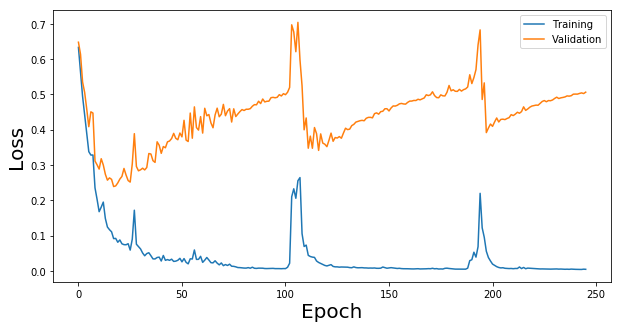

In [11]:
plt.figure(figsize=(10,5))
plt.plot(NN_no_regularization.hist['train_loss'][5::], label="Training")
plt.plot(NN_no_regularization.hist['val_loss'][5::], label="Validation")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend()
plt.show()

#### Now plot the training and validation accuracies over the epochs.

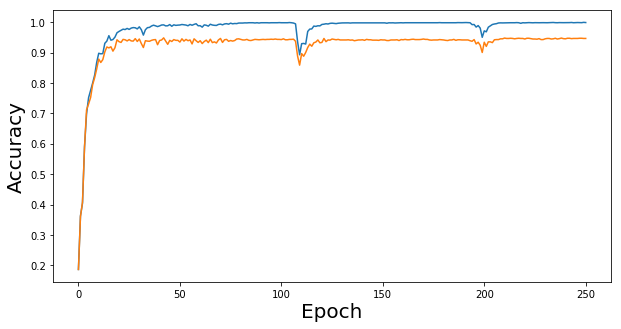

In [12]:
plt.figure(figsize=(10,5))

plt.plot(NN_no_regularization.hist['train_accuracy'])
plt.plot(NN_no_regularization.hist['val_accuracy'])

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)

plt.show()

### $\ell 2$ regularization

Afterwards, we use $\ell 2$ regularization, and we investigate the train/validation/test loss. Set the regularization parameter to 0.01.

In [13]:
NN_L2_regularization = FeedForwardNet(hidden_sizes, layer_types, "L2_regularization", l2_reg=1e-2)
NN_L2_regularization.build(train_data.shape[1], num_classes=train_labels.shape[1])

In [14]:
NN_L2_regularization.train(train_data, train_labels, val_data, val_labels, epochs,
                          batch_size=batch_size)

Epoch 25/250 training loss 0.9284148812294006 training acc 0.7142560482025146 val acc 0.7085927724838257
Epoch 50/250 training loss 0.47270530462265015 training acc 0.9400290250778198 val acc 0.9066002368927002
Epoch 75/250 training loss 0.4488086998462677 training acc 0.9381614327430725 val acc 0.9034869074821472
Epoch 100/250 training loss 0.46533364057540894 training acc 0.9394065141677856 val acc 0.8897882699966431
Epoch 125/250 training loss 0.44785529375076294 training acc 0.9479144811630249 val acc 0.9159402251243591
Epoch 150/250 training loss 0.4204469621181488 training acc 0.9474994540214539 val acc 0.9047322273254395
Epoch 175/250 training loss 0.4302079975605011 training acc 0.9499896168708801 val acc 0.9084682464599609
Epoch 200/250 training loss 0.42192190885543823 training acc 0.9472919702529907 val acc 0.9115815758705139
Epoch 225/250 training loss 0.41944414377212524 training acc 0.9566299915313721 val acc 0.9265255331993103
Epoch 250/250 training loss 0.40436878800392

### Dropout

Finally, we train a model using dropout. Use a dropout rate of 0.5.

In [15]:
NN_dropout_regularization = FeedForwardNet(hidden_sizes, layer_types, "dropout_regularization")
NN_dropout_regularization.build(train_data.shape[1], num_classes=train_labels.shape[1])

In [16]:
#DROPOUT CHANGED TO 0.3 FROM 0.5 AND THE ACCURACY IS IMPROVED. SO KEEPING IT AS 0.3
NN_dropout_regularization.train(train_data, train_labels, val_data, val_labels, epochs,
                          batch_size=batch_size, dropout=0.3)

Epoch 25/250 training loss 0.3150421977043152 training acc 0.9157501459121704 val acc 0.899128258228302
Epoch 50/250 training loss 0.2050514668226242 training acc 0.948744535446167 val acc 0.9196761846542358
Epoch 75/250 training loss 0.13769221305847168 training acc 0.9636853933334351 val acc 0.9259028434753418
Epoch 100/250 training loss 0.11393969506025314 training acc 0.970740795135498 val acc 0.9358655214309692
Epoch 125/250 training loss 0.09989973157644272 training acc 0.9761361479759216 val acc 0.9427148103713989
Epoch 150/250 training loss 0.07942799478769302 training acc 0.9782112240791321 val acc 0.9389788508415222
Epoch 175/250 training loss 0.08456519991159439 training acc 0.9796638488769531 val acc 0.939601480960846
Epoch 200/250 training loss 0.07831404358148575 training acc 0.9800788760185242 val acc 0.9476961493492126
Epoch 225/250 training loss 0.06335553526878357 training acc 0.9852666258811951 val acc 0.939601480960846
Epoch 250/250 training loss 0.06490746140480042

## Comparing the models
Now, compare the final training and validation losses achieved by the different models.

In [17]:
train_acc_noreg = NN_no_regularization.hist['train_accuracy'][-1]
val_acc_noreg = NN_no_regularization.hist['val_accuracy'][-1]

train_acc_L2reg = NN_L2_regularization.hist['train_accuracy'][-1]
val_acc_L2reg = NN_L2_regularization.hist['val_accuracy'][-1]

train_acc_dropoutreg = NN_dropout_regularization.hist['train_accuracy'][-1]
val_acc_dropoutreg = NN_dropout_regularization.hist['val_accuracy'][-1]

In [14]:
print(f"Training accuracy without regularization: {train_acc_noreg:.3f}")
print(f"Validation accuracy without regularization: {val_acc_noreg:.3f}")
print()

print(f"Training accuracy with L2 regularization: {train_acc_L2reg:.3f}")
print(f"Validation accuracy with L2 regularization: {val_acc_L2reg:.3f}")
print()

print(f"Training accuracy with dropout regularization: {train_acc_dropoutreg:.3f}")
print(f"Validation accuracy with dropout regularization: {val_acc_dropoutreg:.3f}")

Training accuracy without regularization: 0.980
Validation accuracy without regularization: 0.938

Training accuracy with L2 regularization: 0.941
Validation accuracy with L2 regularization: 0.913

Training accuracy with dropout regularization: 0.954
Validation accuracy with dropout regularization: 0.922


### Plot the losses and accuracies of the models in one plot to compare them.

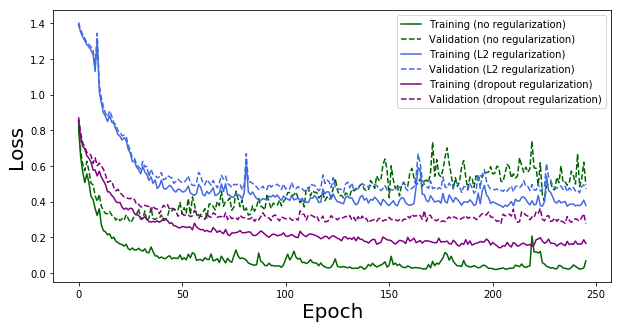

In [15]:
plt.figure(figsize=(10,5))
plt.plot(NN_no_regularization.hist['train_loss'][5::], label="Training (no regularization)",
        color="darkgreen")
plt.plot(NN_no_regularization.hist['val_loss'][5::], label="Validation (no regularization)",
        color="darkgreen", linestyle="--")

plt.plot(NN_L2_regularization.hist['train_loss'][5::], label="Training (L2 regularization)",
        color="royalblue")
plt.plot(NN_L2_regularization.hist['val_loss'][5::], label="Validation (L2 regularization)",
        color="royalblue", linestyle="--")

plt.plot(NN_dropout_regularization.hist['train_loss'][5::], 
         label="Training (dropout regularization)", color="purple")
plt.plot(NN_dropout_regularization.hist['val_loss'][5::], 
         label="Validation (dropout regularization)", color="purple", linestyle="--")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend()
plt.show()

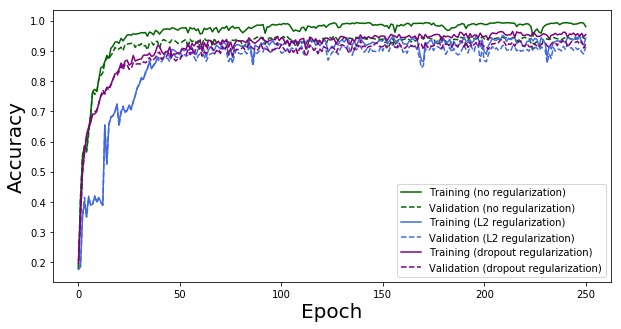

In [16]:
plt.figure(figsize=(10,5))

plt.plot(NN_no_regularization.hist['train_accuracy'], label="Training (no regularization)",
        color="darkgreen")
plt.plot(NN_no_regularization.hist['val_accuracy'], label="Validation (no regularization)",
        color="darkgreen", linestyle="--")

plt.plot(NN_L2_regularization.hist['train_accuracy'], label="Training (L2 regularization)",
        color="royalblue")
plt.plot(NN_L2_regularization.hist['val_accuracy'], label="Validation (L2 regularization)",
        color="royalblue", linestyle="--")

plt.plot(NN_dropout_regularization.hist['train_accuracy'], 
         label="Training (dropout regularization)", color="purple")
plt.plot(NN_dropout_regularization.hist['val_accuracy'], 
         label="Validation (dropout regularization)", color="purple", linestyle="--")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend()
plt.show()

## Challenge

Notice that we also have the variable `test_data`. **Get creative** and build a model yourself!

Submit your predictions of the test data to Moodle to enter the leaderboard. We will announce the winning team after the Christmas break!

You can output the predictions of the test data using:

We will only consider submission as plain text files with **exactly** the following formatting as our `sample_submission.txt`

In [20]:
#Played around with the hyper parameters - learning rate to AdamOptimizer, l2_reg, epochs, batch_size and dropout
#Finally chose the below 0.01, 1e-3, 500, 512, 0 as the values
my_model = FeedForwardNet(hidden_sizes, layer_types, "my_model", l2_reg=1e-3)
my_model.build(train_data.shape[1], num_classes=train_labels.shape[1])
my_model.train(train_data, train_labels, val_data, val_labels, epochs=500, batch_size=batch_size, dropout=0)

test_preds = my_model.logits.eval({my_model.X: test_data},
                                        session=my_model.session).argmax(1)

Epoch 25/500 training loss 0.35112905502319336 training acc 0.8902261853218079 val acc 0.8723536729812622
Epoch 50/500 training loss 0.2307662069797516 training acc 0.9499896168708801 val acc 0.9165629148483276
Epoch 75/500 training loss 0.18983586132526398 training acc 0.9582901000976562 val acc 0.9090909361839294
Epoch 100/500 training loss 0.17067478597164154 training acc 0.9688732028007507 val acc 0.9271482229232788
Epoch 125/500 training loss 0.18724510073661804 training acc 0.9580826163291931 val acc 0.9097135663032532
Epoch 150/500 training loss 0.13204842805862427 training acc 0.9813238978385925 val acc 0.931506872177124
Epoch 175/500 training loss 0.12707918882369995 training acc 0.9863042235374451 val acc 0.9371108412742615
Epoch 200/500 training loss 0.15491145849227905 training acc 0.9744760394096375 val acc 0.9240348935127258
Epoch 225/500 training loss 0.1407649964094162 training acc 0.9763436317443848 val acc 0.9271482229232788
Epoch 250/500 training loss 0.1529074609279

In [18]:
string = ""
with open("sample_submission.txt", "r") as f:
    string = f.read()
print(string[:19])
print("...")

5
3
0
0
4
5
1
2
4
3
...


You can use the following command to save your predictions:

In [22]:
np.savetxt("my_submission.txt", test_preds, fmt='%i')